This notebook contains simulations of the algorithms presented in the paper
"WOR and p's: Sketches for l_p-sampling without replacement" by Cohen, Pagh, and Woodruff, NeurIPS 2020. It is meant to illustrate the performance of the
algorithms, and is not suitable for applying the algorithms in a practical setting. In particular, it considers weight distributions over a domain D={0,...,d-1} that is explicitly represented in a vector of size d, and also simulates random hashing of elements in D by an array of random values. To support large domains, high-quality random hash functions should be used instead. Random choices are seeded, for reproducibility.

Below we use "ppswor" to denote Probability Proportional to Size WithOut Replacement sampling, and "p-ppswor" to denote the generalization in which weights are raised to the power p.

# Imports, setup, and distributions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from numpy.random import default_rng
from google.colab import drive
infinity = float('inf')

gDrive = False # Flag deciding if plots should be written to Google Drive (True) or locally to the colab file system (False)
RUNALL = True # Flag indicating if time-consuming experiments should be run (if not, saved results from an earlier run are loaded)

if gDrive:
  drive.mount('/content/gdrive') # Running this requires entering an authorization code
  folder = "/content/gdrive/My Drive/L2-sampling/" # Assumes that a folder named L2-sampling has been created in Google Drive
else:
  drive.flush_and_unmount()
  folder = ""

Drive not mounted, so nothing to flush and unmount.


In [ ]:
# Distributions, normalized so that weights sum to 1

def normalize(x, ord = 1):
  return x / np.linalg.norm(x, ord = ord)

def uniform_distribution(size):
  return normalize(np.ones(size))

def geometric_distribution(size, p = 0.5):
  return normalize(np.array([(1 - p)**i for i in range(size)]))

def zipf_distribution(size, a = 1.0):
  return normalize(np.array([(i+1)**(-a) for i in range(size)]))


# The p-ppswor transform

Method applying the p-ppswor transform to weights (that is, scaling by inverse exponentials).

In [ ]:
def scale_by_inverse_exponentials(x, norm = 1, seed = None):
  rng = default_rng(seed)
  return x / np.power(rng.exponential(size = x.size), 1/norm)

The method is illustrated by the below bar plot. Original distribution are the blue bars, the transformed weights are shown in orange. The bars above the horizontal line are selected (ideally) by a heavy hitters data structure, and form the l_p sample.

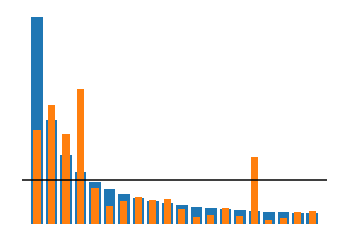

In [ ]:
support_size = 20
x = zipf_distribution(support_size)
# x = np.random.permutation(x)
y = normalize(scale_by_inverse_exponentials(x, norm=2))
plt.axis('off')
plt.bar(range(1,support_size+1), x)
plt.savefig(folder + "distribution.png")
plt.bar(range(1,support_size+1), y, 0.5)
plt.savefig(folder + "scaling_by_inverse_exponentials.png")
plt.hlines(np.nanquantile(y,0.75),0,support_size+1)
plt.savefig(folder + "scaling_by_inverse_exponentials_with_threshold.png")
plt.show()

# Perfect ppswor

The following methods implement p-ppswor using exact top-k heavy hitters on the transformed weights. This cannot be implemented in low space, but serves as a baseline against which the heavy hitters sketches can be compared. A method for computing sampling probabilities is provided for use when estimating a sum from a sample.

In [ ]:
# Helper method, find indices of top elements in an array
def heavy_hitter_indices(x, k):
  k = min([k, x.size]) # Cannot sample more than all
  return sorted(np.argpartition(x, -k)[-k:].tolist())

# Perfect p-ppswor, default norm is p = 1:
def perfect_lp_wor_sample(x, size = 1, norm = 1, seed = None):
  x_scaled = scale_by_inverse_exponentials(x, norm = norm, seed = seed)
  top_k_indices = heavy_hitter_indices(x_scaled, size)
  threshold = min(x_scaled[heavy_hitter_indices(x_scaled, size + 1)])
  return top_k_indices, x[top_k_indices], threshold

def lp_wor_sampling_probability(value, threshold, norm = 1):
  # Compute probability that element of given value is sampled, given threshold (k+1)st transformed value
  # = Pr(value / r^(1/norm) > threshold) = Pr(r < (value/threshold)^norm)
  return 1 - np.exp(- np.power(value / threshold, norm))


# Perfect Lp sampling with replacement

The following methods implement with-replacement l_p sampling. This serves as another baseline against which our algorithms can be compared. A method for computing sampling probabilities is provided for use when estimating a sum from a sample.

In [ ]:
# Perfect lp sampling with replacement (actual results are worse in 1 pass)
def with_replacement_lp_sampling(distribution, sample_size, norm = 1, seed = None):
  rng = default_rng(seed)
  d = distribution.size
  probabilities = normalize(np.power(distribution, norm))
  sample = np.unique(np.random.choice(range(d), sample_size, p=probabilities))
  return sample, distribution[sample]

def lp_wr_sampling_probability(value, sample_size, distribution, norm = 1):
  total_weight = np.sum(np.power(distribution, norm))
  return 1 - np.power(1 - np.power(value, norm) / total_weight, sample_size)


# Count sketch

Simulation of a count sketch populated by elements of given weights. The implementation represents random hash functions in a trivial way, as arrays of random values. An implementation to be used over large domains would have to replace this with high-quality random hash functions. The decoding procedure works by estimating the weight of every element in the domain. To support large domains, more efficient heavy hitters algorithms should be used.

In [ ]:
# Construct lookup tables for hash functions
def compute_hashes(repetitions, dimension, table_size, seed = None):
  rng = default_rng(seed)
  hash_values = rng.choice(table_size, size = (repetitions, dimension))
  sign_values = 2 * rng.choice(2, size = (repetitions, dimension)) - 1
  return hash_values, sign_values

# Compute count sketch of vector x
def count_sketch(x, sketch_size, repetitions = 15, seed = None):
  dimension = x.size
  table_size = sketch_size // repetitions
  hash_values, sign_values = compute_hashes(repetitions, dimension, table_size, seed)
  result = np.zeros(shape = (repetitions, table_size))
  for i in range(repetitions):
    for j in range(dimension):
      result[i, hash_values[i, j]] += sign_values[i, j] * x[j]
  return result

# Decode vector from count sketch as median of estimators
def decode_count_sketch(sketch, dimension, seed = None):
  (repetitions, table_size) = sketch.shape
  hash_values, sign_values = compute_hashes(repetitions, dimension, table_size, seed)
  estimators = np.zeros(shape = (repetitions, dimension))
  for i in range(repetitions):
    for j in range(dimension):
      estimators[i, j] = sign_values[i, j] * sketch[i, hash_values[i, j]]
  return np.median(estimators, axis = 0)


# WORp sampling

Implementation of WORp sampling, in 1-pass and 2-pass versions. In the latter, exact weights for the set of k heavy hitters (computed in the second pass for a set of 3k candidate heavy hitters) are used. The implementation uses, by default, count sketch with 15 repetitions and table size 2k (30k total space) as heavy hitters data structure.

In [ ]:
COUNT_SKETCH_OVERHEAD = 2 # Ratio between count sketch table size and sample size

# Helper method, using count sketch on the raw data:
def sketch_decode(distribution, sketch_size, repetitions = 15, seed = None):
  dimension = distribution.size
  sketch = count_sketch(distribution, sketch_size, repetitions = repetitions, seed = seed)
  return decode_count_sketch(sketch, dimension, seed = seed)

# 1-pass WORp:
def scale_sketch_decode_estimate(distribution, sample_size, repetitions = 15, norm = 2, seed = None):
  sketch_size = COUNT_SKETCH_OVERHEAD * sample_size * repetitions
  scaled_distribution = scale_by_inverse_exponentials(distribution, norm = norm, seed = seed)
  scaled_estimates = sketch_decode(scaled_distribution, sketch_size, repetitions, seed = seed)
  threshold = min(scaled_estimates[heavy_hitter_indices(scaled_estimates, sample_size + 1)])
  sample = heavy_hitter_indices(scaled_estimates, sample_size)
  estimates = scale_by_inverse_exponentials(scaled_estimates, norm = -norm, seed = seed)
  return sample, estimates[sample], threshold

# 2-pass WORp:
def scale_sketch_decode(distribution, sample_size, repetitions = 15, norm = 2, seed = None):
  sketch_size = COUNT_SKETCH_OVERHEAD * sample_size * repetitions
  scaled_distribution = scale_by_inverse_exponentials(distribution, norm = norm, seed = seed)
  scaled_estimates = sketch_decode(scaled_distribution, sketch_size, repetitions, seed = seed)
  candidate_set_size = 3 * sample_size
  candiate_set = heavy_hitter_indices(scaled_estimates, candidate_set_size)
  scaled_distribution_candidates = np.zeros(scaled_distribution.size)
  for i in candiate_set:
    scaled_distribution_candidates[i] = scaled_distribution[i]
  best_candidates = heavy_hitter_indices(scaled_distribution_candidates, sample_size + 1)
  threshold = min(scaled_distribution[best_candidates])
  sample = heavy_hitter_indices(scaled_distribution, sample_size)
  return sample, distribution[sample], threshold

# Methods for estimating frequency by rank

The following methods are used for running experiments. The first two methods call the appropriate implementation for a given number of passes, without or with repetitions.

In [ ]:
def lp_wor(distribution, sample_size, norm = 1, passes = 2, repetitions = 15, seed = None):
  if passes == 2:
    sample, sample_values, threshold = scale_sketch_decode(distribution, sample_size, repetitions = repetitions, norm = norm, seed = seed)
  elif passes == 1:
    sample, sample_values, threshold = scale_sketch_decode_estimate(distribution, sample_size, repetitions = repetitions, norm = norm, seed = seed)
  elif passes == infinity:
    sample, sample_values, threshold = perfect_lp_wor_sample(distribution, sample_size, norm, seed = seed)
  else:
    raise Exception("Unsupported number of passes: " + str(passes))
  sample_values = sorted(sample_values, reverse=True)
  weights = np.power(lp_wor_sampling_probability(sample_values, threshold, norm = norm), -1)
  return sample_values, np.cumsum(weights)

def lp_wr(distribution, sample_size, norm = 1, seed = None):
  sample, sample_values = with_replacement_lp_sampling(distribution, sample_size, norm = norm, seed = seed)
  sample_values = sorted(sample_values, reverse=True)
  weights = np.power(lp_wr_sampling_probability(sample_values, sample_size, distribution, norm = norm), -1)
  return sample_values, np.cumsum(weights)

The following method produces a plot of estimated rank-frequency distributions for different algorithms based on the p-ppswor transformation.

In [ ]:
def worp_rank_frequency_plot(distribution, sample_size, distribution_name = "", filename = "", norm = 2, repetitions = 15, seed = None):
  plt.loglog(range(1,d+1), distribution, label='Actual' + distribution_name)
  sample_values, cummulative_weights,  = lp_wor(distribution, sample_size, norm = norm, passes = infinity, seed = seed)
  plt.loglog(cummulative_weights, sample_values, label='Perfect WOR L'+str(norm)+' sample', marker = 'd', markevery= [0, -1])
  sample_values, cummulative_weights = lp_wr(distribution, sample_size, norm = norm, seed = seed)
  plt.loglog(cummulative_weights, sample_values, label='Perfect WR L'+str(norm)+' sample', marker = 'd', markevery= [0, -1])
  sample_values, cummulative_weights = lp_wor(distribution, sample_size, norm = norm, passes = 1, repetitions = repetitions, seed = seed)
  plt.loglog(cummulative_weights, sample_values, label='1-pass WORp, p='+str(norm), marker = '.', markevery= [0, -1])
  sample_values, cummulative_weights = lp_wor(distribution, sample_size, norm = norm, passes = 2, repetitions = repetitions, seed = seed)
  plt.loglog(cummulative_weights, sample_values, label='2-pass WORp, p='+str(norm), marker = '.', markevery= [0, -1])
  plt.xlabel("Rank")
  plt.ylabel("Frequency")
  plt.title("Estimated distribution of frequency by rank from L"+str(norm)+" samples\n(sample size "+str(sample_size)+", support size "+str(distribution.size)+")")
  plt.legend()
  plt.savefig(folder + "rank-frequency-distribution-L" +str(norm) + "-" + str(sample_size) + '-' + filename + ".pdf")
  plt.show()

def zipf_worp_rank_frequency_plot(dimension, a, sample_size, norm = 2, repetitions = 3, seed = None):
  worp_rank_frequency_plot(zipf_distribution(dimension, a = a), sample_size, ', Zipf '+str(round(a,2)), 'zipf-'+str(round(a,2)), norm = norm, repetitions = repetitions, seed = seed)


The following method produces a plot of estimated rank-frequency distributions for pure (exact) l_p samples.

In [ ]:
def pure_rank_frequency_plot(distribution, sample_size, distribution_name = "", filename = "", seed = None):
  plt.loglog(range(1,d+1), distribution, label='Actual' + distribution_name)
  sample_values, cummulative_weights,  = lp_wor(distribution, sample_size, norm = 1, passes = infinity, seed = seed)
  plt.loglog(cummulative_weights, sample_values, label='Perfect WOR L1 sample', marker = 'd', markevery= [0, -1])
  sample_values, cummulative_weights,  = lp_wor(distribution, sample_size, norm = 2, passes = infinity, seed = seed)
  plt.loglog(cummulative_weights, sample_values, label='Perfect WOR L2 sample', marker = 'd', markevery= [0, -1])
  sample_values, cummulative_weights = lp_wr(distribution, sample_size, norm = 1, seed = seed)
  plt.loglog(cummulative_weights, sample_values, label='Perfect WR L1 sample', marker = '.', markevery= [0, -1])
  sample_values, cummulative_weights = lp_wr(distribution, sample_size, norm = 2, seed = seed)
  plt.loglog(cummulative_weights, sample_values, label='Perfect WR L2 sample', marker = '.', markevery= [0, -1])
  plt.xlabel("Rank")
  plt.ylabel("Frequency")
  plt.title("Estimated distribution of frequency by rank from perfect L1/L2 samples\n(sample size "+str(sample_size)+", support size "+str(distribution.size)+")")
  plt.legend()
  plt.savefig(folder + "rank-frequency-distribution-pure-" + str(sample_size) + '-' + filename + ".pdf")
  plt.show()

def zipf_pure_rank_frequency_plot(dimension, a, sample_size, seed = None):
  pure_rank_frequency_plot(zipf_distribution(dimension, a = a), sample_size, ', Zipf '+str(round(a,2)), 'zipf-'+str(round(a,2)), seed = seed)


# Plots for frequency by rank

In [ ]:
# Common parameters for all experiments
d = 10000
sample_size = 100
reps = 15 # This number of repetitions was found to be sufficient to ensure a low error probability on the count sketch
seed = 1

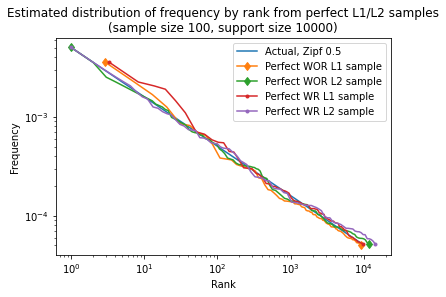

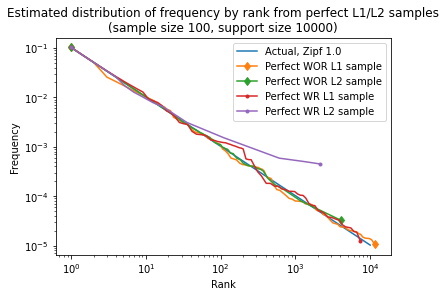

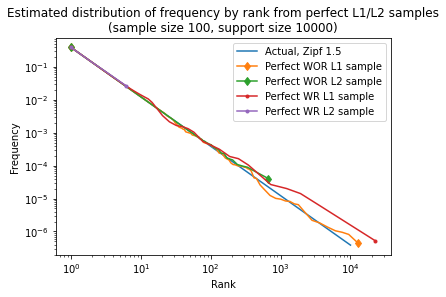

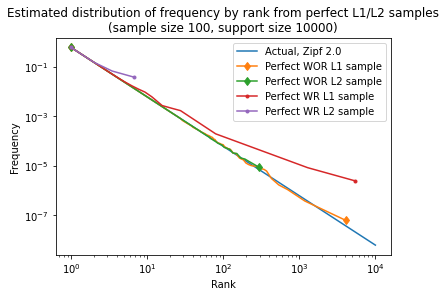

In [ ]:
# Plots for pure/perfect Lp sampling
zipf_pure_rank_frequency_plot(d, 0.5, sample_size, seed = seed)
zipf_pure_rank_frequency_plot(d, 1.0, sample_size, seed = seed)
zipf_pure_rank_frequency_plot(d, 1.5, sample_size, seed = seed)
zipf_pure_rank_frequency_plot(d, 2.0, sample_size, seed = seed)

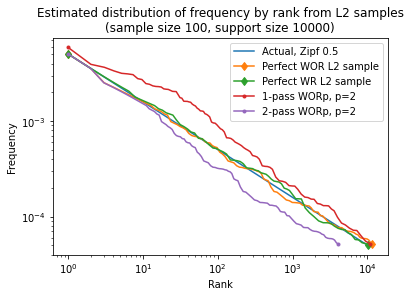

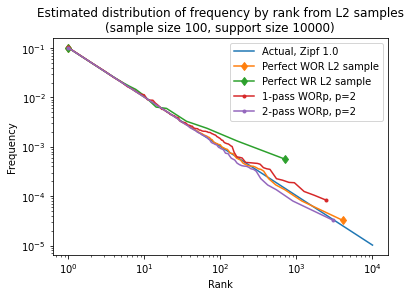

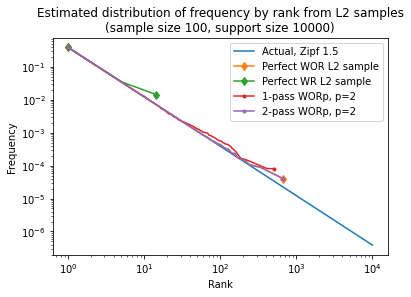

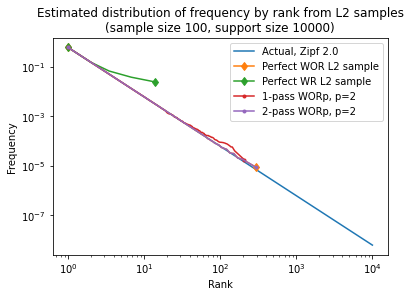

In [ ]:
# Plots for L2 sampling
zipf_worp_rank_frequency_plot(d, 0.5, sample_size, norm = 2, repetitions = reps, seed = seed)
zipf_worp_rank_frequency_plot(d, 1.0, sample_size, norm = 2, repetitions = reps, seed = seed)
zipf_worp_rank_frequency_plot(d, 1.5, sample_size, norm = 2, repetitions = reps, seed = seed)
zipf_worp_rank_frequency_plot(d, 2.0, sample_size, norm = 2, repetitions = reps, seed = seed)

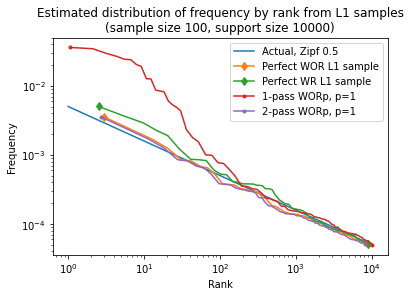

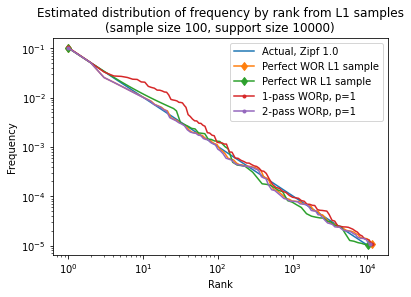

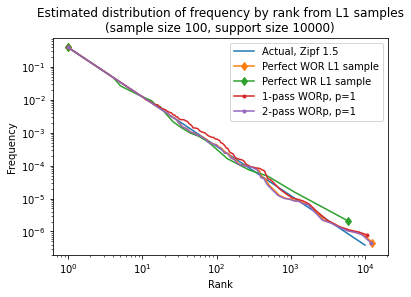

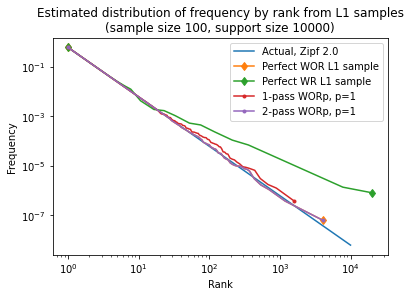

In [ ]:
# Plots for L1 sampling
zipf_worp_rank_frequency_plot(d, 0.5, sample_size, norm = 1, repetitions = reps, seed = seed)
zipf_worp_rank_frequency_plot(d, 1.0, sample_size, norm = 1, repetitions = reps, seed = seed)
zipf_worp_rank_frequency_plot(d, 1.5, sample_size, norm = 1, repetitions = reps, seed = seed)
zipf_worp_rank_frequency_plot(d, 2.0, sample_size, norm = 1, repetitions = reps, seed = seed)

# Effective sample size

The following experiments illustrate the power of WOR sampling for distributions dominated by a small number of elements. For simplicity this is shown for pure WOR l_p-sampling.

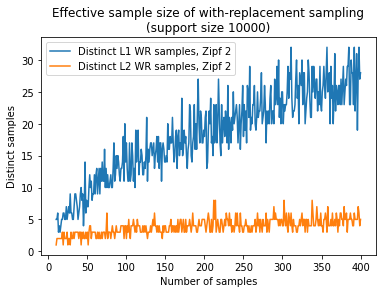

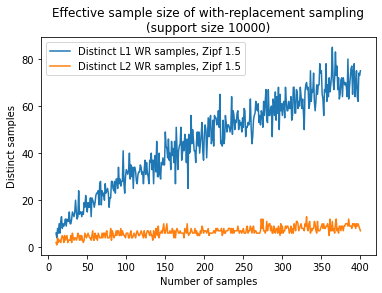

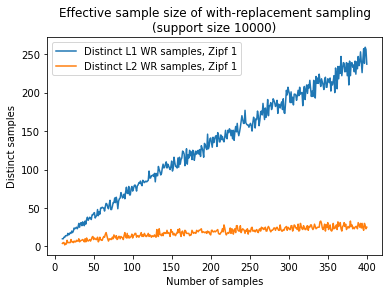

In [ ]:
def zipf_wr_distinct_samples(dimension, a, sample_size, norm = 1):
  sample, _ = with_replacement_lp_sampling(zipf_distribution(dimension, a = a), sample_size, norm = norm)
  return len(sample)

d = 10000
a = 2
max_size = 400

def plot_zipf_effective_sample_size(dimension, a, max_sample_size):
  sample_sizes = range(10, max_sample_size + 1)
  distinct_samples_l1 = [ zipf_wr_distinct_samples(dimension, a, sample_size, norm = 1) for sample_size in sample_sizes ]
  distinct_samples_l2 = [ zipf_wr_distinct_samples(dimension, a, sample_size, norm = 2) for sample_size in sample_sizes ]
  plt.plot(sample_sizes, distinct_samples_l1, label='Distinct L1 WR samples, Zipf '+str(round(a,2)))
  plt.plot(sample_sizes, distinct_samples_l2, label='Distinct L2 WR samples, Zipf '+str(round(a,2)))
  plt.xlabel("Number of samples")
  plt.ylabel("Distinct samples")
  plt.title("Effective sample size of with-replacement sampling\n(support size "+str(dimension)+")")
  plt.legend()
  plt.savefig(folder + "effective-sample-size-" + str(max_sample_size) + "-zipf-" +str(round(a,2)) + ".pdf")
  plt.show()

plot_zipf_effective_sample_size(d, 2, max_size)
plot_zipf_effective_sample_size(d, 1.5, max_size)
plot_zipf_effective_sample_size(d, 1, max_size)


# Moment estimation

An application of our algorithms is estimating frequency moments from an l_p sample. To get stable results we increase the number of repetitions for count sketch to 31. The experiments focus on 3rd frequency moments which are know to require polynomial space for worst-case input streams, but are tractable for skewed weight distributions. See "Composable Sketches for Functions of Frequencies: Beyond the Worst Case" by Cohen, Geri, and Pagh, International Conference on Machine Learning (ICML), 2020.

In [ ]:
def lp_wor_moment(distribution, sample_size, moment = 3, norm = 2, passes = 2, repetitions = 31, tail_start = 0, seed = None):
  if passes == 2:
    sample, sample_values, threshold = scale_sketch_decode(distribution, sample_size, norm = norm, repetitions = repetitions, seed = seed)
  elif passes == 1:
    sample, sample_values, threshold = scale_sketch_decode_estimate(distribution, sample_size, norm = norm, repetitions = repetitions, seed = seed)
  elif passes == infinity:
    sample, sample_values, threshold = perfect_lp_wor_sample(distribution, sample_size, norm, seed = seed)
  else:
    raise Exception("Unsupported number of passes: " + str(passes))
  tail_values = []
  for i in range(len(sample)):
    if sample[i] >= tail_start:
      tail_values.append(sample_values[i])
  return np.dot(np.power(lp_wor_sampling_probability(tail_values, threshold, norm = norm), -1), np.power(tail_values, moment))

def lp_wr_moment(distribution, sample_size, moment = 3, norm = 2, tail_start = 0, seed = None):
  sample, sample_values = with_replacement_lp_sampling(distribution, sample_size, norm = norm, seed = seed)
  sample_values = sorted(sample_values, reverse=True)
  tail_values = []
  for i in range(len(sample)):
    if sample[i] >= tail_start:
      tail_values.append(sample_values[i])
  return np.dot(np.power(lp_wr_sampling_probability(tail_values, sample_size, distribution, norm = norm), -1), np.power(tail_values, moment))

In [ ]:
d = 10000
sample_size = 100
norm = 2 # norm is <=2
runs = 5
tail_start = 2
moment = 3 # what we estimate
reps = 31
a = 2
x = zipf_distribution(d, a = a)
rep_factor = 1

def moment_estimates(distribution, sample_size, norm = 2, passes = 1, moment = 3, repetitions = 31, tail_start = 0, runs = 100):
  worp_estimates_1pass = []
  worp_estimates_2pass = []
  wr_estimates = []
  wor_estimates = []
  for i in range(runs):
    worp_estimates_1pass.append(lp_wor_moment(distribution, sample_size, norm = norm, passes = 1, moment = moment, repetitions =  rep_factor*repetitions, tail_start = tail_start, seed = i))
    worp_estimates_2pass.append(lp_wor_moment(distribution, sample_size, norm = norm, passes = 2, moment = moment, repetitions = repetitions, tail_start = tail_start, seed = i))
    wr_estimates.append(lp_wr_moment(distribution, sample_size, norm = norm, moment = moment, tail_start = tail_start, seed = i))
    wor_estimates.append(lp_wor_moment(distribution, sample_size, norm = norm, passes = infinity, moment = moment, tail_start = tail_start, seed = i))
  return np.array(wr_estimates), np.array(wor_estimates), np.array(worp_estimates_1pass), np.array(worp_estimates_2pass)

if RUNALL:
  worp_estimates_1pass, worp_estimates_2pass, wr_estimates, wor_estimates = moment_estimates(x, sample_size, norm = norm, passes = 1, moment = moment, repetitions = reps, tail_start = tail_start, runs = runs)

  pickle.dump(worp_estimates_1pass, open("worp_estimates_1pass.pickle", "wb"))
  pickle.dump(worp_estimates_2pass, open("worp_estimates_2pass.pickle", "wb"))
  pickle.dump(wr_estimates, open("wr_estimates.pickle", "wb"))
  pickle.dump(wor_estimates, open("wor_estimates.pickle", "wb"))



In [ ]:
worp_estimates_1pass = pickle.load(open("worp_estimates_1pass.pickle", "rb"))
worp_estimates_2pass = pickle.load(open("worp_estimates_2pass.pickle", "rb"))
wr_estimates = pickle.load(open("wr_estimates.pickle", "rb"))
wor_estimates = pickle.load(open("wor_estimates.pickle", "rb"))


true_tail_moment = np.sum(np.power(x[tail_start:], moment))

wr_nrmse = np.sum(np.power(wr_estimates - true_tail_moment, 2) / runs)** 0.5 / true_tail_moment
wor_nrmse = np.sum(np.power(wor_estimates - true_tail_moment, 2) / runs)** 0.5 / true_tail_moment
worp_1p_nrmse = np.sum(np.power(worp_estimates_1pass - true_tail_moment, 2) / runs)** 0.5 / true_tail_moment
worp_2p_nrmse = np.sum(np.power(worp_estimates_2pass - true_tail_moment, 2) / runs)** 0.5 / true_tail_moment


print("Sampling from Zipf", a, "ignoring top", tail_start, "heaviest elements, sample size", str(sample_size) + ", "+str(runs)+" runs")
print("True tail F"+str(moment)+": ", true_tail_moment)

print("Perfect WR L2, relative mean squared error:",
      np.sum(np.power(wr_estimates - true_tail_moment, 2) / runs)** 0.5 / true_tail_moment)
print("Perfect WOR L2, relative mean squared error:",
      np.sum(np.power(wor_estimates - true_tail_moment, 2) / runs)** 0.5 / true_tail_moment)
print("1-pass WORp, relative mean squared error:",
      np.sum(np.power(worp_estimates_1pass - true_tail_moment, 2) / runs)** 0.5 / true_tail_moment)
print("2-pass WORp, relative mean squared error:",
      np.sum(np.power(worp_estimates_2pass - true_tail_moment, 2) / runs)** 0.5 / true_tail_moment)


print("ellp alpha moment tail-start perfect WR, WOR  1-pass WORp 2-pass WORp ")
print(norm, " : ", a, "&" , moment, "&", tail_start, '& {:0.2e}'.format(wr_nrmse), '& {:0.2e}'.format(wor_nrmse), '& {:0.2e}'.format(worp_1p_nrmse), '& {:0.2e}'.format(worp_2p_nrmse))



Sampling from Zipf 2 ignoring top 2 heaviest elements, sample size 100, 5 runs
True tail F3:  0.0003860757711278855
Perfect WR L2, relative mean squared error: 0.0002904512989319339
Perfect WOR L2, relative mean squared error: 8.524278272185711e-09
1-pass WORp, relative mean squared error: 0.5107438721549251
2-pass WORp, relative mean squared error: 8.524278272185711e-09
ellp alpha moment tail-start perfect WR, WOR  1-pass WORp 2-pass WORp 
2  :  2 & 3 & 2 & 2.90e-04 & 8.52e-09 & 5.11e-01 & 8.52e-09


# Monte Carlo simulations for Psi

Below are some simulations related to Theorem 5.1 in the paper. These simulations are not described in the paper.

In [ ]:
# Sample from distribution of Definition 3.2

def R(k, n, rho = 1, size = 1):
  rng = default_rng()
  exponential_distr = rng.exponential(size = (size, n))
  cumsum_to_rho = np.power(np.cumsum(exponential_distr, axis = 1), rho)
  numerator = cumsum_to_rho[:, k - 1].reshape(size, 1)
  denominator = cumsum_to_rho[:, k:]
  return np.sum(numerator / denominator, axis = 1)

In [ ]:
# Empirical CDF of distribution
k = 1000
n = 100000
trials = 1000
sample_rho_1 = sorted(list(R(k, n, rho = 1, size = trials)))
sample_rho_2 = sorted(list(R(k, n, rho = 2, size = trials)))

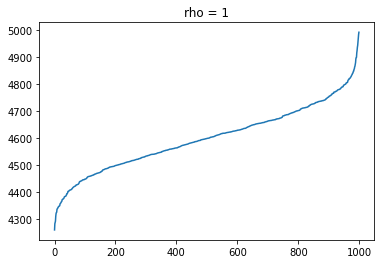

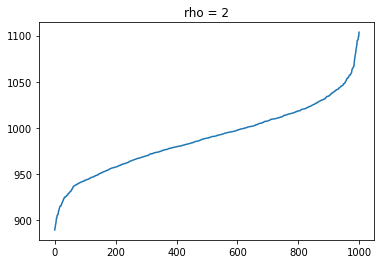

In [ ]:
import matplotlib.pyplot as plt
plt.plot(sample_rho_1)
plt.title("rho = 1")
plt.show()
plt.plot(sample_rho_2)
plt.title("rho = 2")
plt.show()

This suggests that a small constant c < 2 may be chosen in Theorem 5.1 of the paper to get very good tail bounds in practice.

In [ ]:
import math
print('rho=1:',sample_rho_1[int(0.99*trials)]/(k* math.log(n/k)))
print('rho=2:',sample_rho_2[int(0.99*trials)]/k)


rho=1: 1.0634691823383857
rho=2: 1.0865866516803513
